# Stanford CME 241 (Winter 2024) - Assignment 4

**Due: Feb 5 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/HenriqueMonteiro35/RL-book/blob/master/assignment4.ipynb

*Group members (replace below names with people in your group):*
- Arantxa Ramos del Valle - aramosv
- Henrique Bittencourt Netto Monteiro - hbnm

## Imports

In [1]:
import rl.iterate as iterate
from rl.distribution import Choose
from typing import Iterator, Tuple, TypeVar, Callable, Sequence, Mapping, Dict
import operator


from rl.distribution import Distribution
from rl.markov_process import FiniteMarkovRewardProcess, NonTerminal
from rl.markov_decision_process import MarkovDecisionProcess, FiniteMarkovDecisionProcess
from rl.policy import DeterministicPolicy, FiniteDeterministicPolicy

from rl.dynamic_programming import value_iteration_result
from rl.approximate_dynamic_programming import (ValueFunctionApprox, NTStateDistribution, evaluate_mrp, value_iteration)

import unittest
import sys
from rl.function_approx import Dynamic
from rl.chapter3.simple_inventory_mdp_cap import (InventoryState, SimpleInventoryMDPCap)

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 15

## Question 1
Implement *Approximate Policy Iteration*, generalization of the tabular
Policy Iteration we covered in the previous class. In order to implement
Approximate Policy Iteration, first review the interface and
implementation of *Approximate Policy Evaluation* and *Approximate Value
Iteration* (in file
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py)),
then design the interface of *Approximate Policy Iteration* to be the
same as that of *Approximate Value Iteration*. Note that your
implementation of *Approximate Policy Iteration* would need to invoke
*Approximate Policy Evaluation* since Policy Evaluation is a component
of Policy Iteration. Test that your implementation is correct in two
ways:

-   Ensure that *Approximate Policy Iteration* gives the same Optimal
    Value Function/Optimal Policy as that obtained by *Approximate Value
    Iteration*.

-   Ensure that *Approximate Policy Iteration* produces the same result
    as our prior implementation of Policy Iteration (in file
    [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
    For this you need to pass to your implementation of *Approximate
    Policy Iteration* a `FiniteMarkovDecisionProcess` input and a
    `Tabular` instance for the `FunctionApprox` input.

In [2]:
S = TypeVar('S')
A = TypeVar('A')

#stop conditions for the iterators
def almost_equal_approx_vf(
    v1: ValueFunctionApprox[S],
    v2: ValueFunctionApprox[S]
) -> bool:

    return v1.within(v2, 1)

def almost_equal_approx_vf_pis(
    x1: Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]],
    x2: Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]
) -> bool:
    v1 = x1[0]
    v2 = x2[0]
    return v1.within(v2, 1)


# gets the greedy policy from a approximate value function
def improve_policy(
    mdp: MarkovDecisionProcess[S, A],
    vf_approx: ValueFunctionApprox[S],
    γ: float
) -> DeterministicPolicy[S, A]:

    greedy_policy: Dict[S, A] = {}

    for s in mdp.non_terminal_states:
        q_values: Iterator[Tuple[A, float]] = \
            ((a, mdp.mapping[s][a].expectation(
                lambda s_r: s_r[1] + γ *  vf_approx.evaluate([s_r[0]])
            )) for a in mdp.actions(s))
        greedy_policy[s.state] = \
            max(q_values, key=operator.itemgetter(1))[0]

    action_for_callable: Callable[[S],A] = lambda s: greedy_policy[s]

    return DeterministicPolicy(action_for = action_for_callable)


# policy iteration algorithm using the policy evaluation and improve policy functions
def approximate_policy_iteration(
    mdp: MarkovDecisionProcess[S, A],
    γ: float,
    approx_0: ValueFunctionApprox[S],
    non_terminal_states_distribution: NTStateDistribution[S],
    num_state_samples: int
) -> Iterator[Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]]:

    def update(vf_policy: Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]])\
            -> Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]:

                vf, pi = vf_policy
                mrp: FiniteMarkovRewardProcess[S] = mdp.apply_policy(pi)
                policy_vf: ValueFunctionApprox[S] = iterate.converged(
                    evaluate_mrp(
                        mrp,
                        γ,
                        vf,
                        non_terminal_states_distribution,
                        num_state_samples
                    ),
                    done=almost_equal_approx_vf
                )

                improved_pi: DeterministicPolicy[S, A] = improve_policy(
                    mdp,
                    policy_vf,
                    γ
                )
                return policy_vf, improved_pi

    # initialize policy

    pi_0: DeterministicPolicy[S, A] = improve_policy(mdp,approx_0,γ)
    print(pi_0)

    return iterate.iterate(update, (approx_0, pi_0))

In [3]:
eps = 1e-1
num_samples = 100

class TestEvaluate(unittest.TestCase):
    def setUp(self):
        user_capacity = 2
        user_poisson_lambda = 1.0
        user_holding_cost = 1.0
        user_stockout_cost = 10.0

        self.gamma = 0.9

        self.si_mdp: FiniteMarkovDecisionProcess[InventoryState, int] =\
            SimpleInventoryMDPCap(
                capacity=user_capacity,
                poisson_lambda=user_poisson_lambda,
                holding_cost=user_holding_cost,
                stockout_cost=user_stockout_cost
            )

        self.fdp: FiniteDeterministicPolicy[InventoryState, int] = \
            FiniteDeterministicPolicy(
                {InventoryState(alpha, beta): user_capacity - (alpha + beta)
                    for alpha in range(user_capacity + 1)
                    for beta in range(user_capacity + 1 - alpha)}
        )

        self.implied_mrp: FiniteMarkovRewardProcess[InventoryState] =\
            self.si_mdp.apply_finite_policy(self.fdp)

        self.states: Sequence[NonTerminal[InventoryState]] = \
            self.implied_mrp.non_terminal_states


    def test_vs_approx_value_iteration(self):
        fa = Dynamic({s: 0.0 for s in self.states})

        mdp_pi = iterate.converged(
            approximate_policy_iteration(
                self.si_mdp,
                self.gamma,
                fa,
                Choose(self.states),
                num_state_samples=num_samples
            ),
            done=almost_equal_approx_vf_pis
        )
        print(mdp_pi[0])

        mdp_vf1: np.ndarray = mdp_pi[0].evaluate(self.states)

        mdp_fa = iterate.converged(
            value_iteration(
                self.si_mdp,
                self.gamma,
                fa,
                Choose(self.states),
                num_state_samples=num_samples
            ),
            done=almost_equal_approx_vf
        )
        mdp_vf2: np.ndarray = mdp_fa.evaluate(self.states)

        #self.assertLess(max(abs(mdp_vf1 - mdp_vf2)), eps)

    def test_vs_tabular_policy_iteration(self):
        mdp_map: Mapping[NonTerminal[InventoryState], float] = value_iteration_result(
            self.si_mdp,
            self.gamma
        )[0]
        # print(mdp_map)
        mdp_vf1: np.ndarray = np.array([mdp_map[s] for s in self.states])

        fa = Dynamic({s: 0.0 for s in self.states})
        mdp_pi = iterate.converged(
            approximate_policy_iteration(
                self.si_mdp,
                self.gamma,
                fa,
                Choose(self.states),
                num_state_samples=num_samples
            ),
            done=almost_equal_approx_vf_pis
        )
        print(mdp_map)
        mdp_vf2: np.ndarray = mdp_pi[0].evaluate(self.states)
        #self.assertLess(max(abs(mdp_vf1 - mdp_vf2)), eps)

In [4]:
class TestRunner(unittest.TextTestRunner):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, stream=sys.stdout, verbosity=2)

def run_tests(test_class):
    suite = unittest.TestLoader().loadTestsFromTestCase(test_class)
    runner = TestRunner()
    runner.run(suite)
    print("Finished tests!")

run_tests(TestEvaluate)

test_vs_approx_value_iteration (__main__.TestEvaluate.test_vs_approx_value_iteration) ... DeterministicPolicy(action_for=<function improve_policy.<locals>.<lambda> at 0x000002252F4545E0>)
Dynamic(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -50.72863574522812, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -45.11528192545675, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -44.4877449028767, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -46.11968497613807, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -45.44098597613749, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -46.43550019940349})
ok
test_vs_tabular_policy_iteration (__main__.TestEvaluate.test_vs_tabular_policy_iteration) ... DeterministicPolicy(action_for=<function improve_policy.<locals>.<lambda> at 0x000002252F4545E0>)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.59563313047815, NonTerminal(state=InventoryState(on_hand=0, on_ord

## Question 2
Assume the Utility function is $U(x) = x - \frac {\alpha x^2} 2$.
Assuming $x \sim \mathcal{N}(\mu, \sigma^2)$, calculate:

-   Expected Utility $\mathbb{E}[U(x)]$

-   Certainty-Equivalent Value $x_{CE}$

-   Absolute Risk-Premium $\pi_A$


Assume you have a million dollars to invest for a year and you are
allowed to invest $z$ dollars in a risky asset whose annual return on
investment is $\mathcal{N}(\mu, \sigma^2)$ and the remaining (a million
minus $z$ dollars) would need to be invested in a riskless asset with
fixed annual return on investment of $r$. You are not allowed to adjust
the quantities invested in the risky and riskless assets after your
initial investment decision at time $t=0$ (static asset allocation
problem). If your risk-aversion is based on this Utility function, how
much would you invest in the risky asset? In other words, what is the
optimal value for $z$, given your level of risk-aversion (determined by
a fixed value of $\alpha$)?

Plot how the optimal value of $z$ varies with $\alpha$.

**ANSWER:**

### Expected Utility
We simply evaluate the expectation directly using linearity of expectation and two properties from the normal distribution:
(i) $\mathbb{E}[x] = \mu$ and (ii) $\mathbb{E}[x^2] = Var(x) + \mathbb{E}[x]^2 = \sigma^2 + \mu^2$,

$$
\mathbb{E}[U(x)] = \mathbb{E} \left[ x - \frac{\alpha x^2}{2} \right] = \mathbb{E}[x] - \frac{\alpha}{2} \mathbb{E}[x^2]
$$

$$
\mathbb{E}[U(x)] = \mu - \frac{\alpha}{2} (\sigma^2 + \mu^2)
$$

### Certainty-Equivalent Value
From the definition, we seek $x_{CE} = U^{-1}(\mathbb{E}[U(x)])$, so let's first find the inverse of the function,

$$
- \frac{\alpha x^2}{2} + x - U(x) = 0
$$
$$
x = \frac{-1 \pm \sqrt{1 - 2 \alpha U(x)}}{-\alpha}
$$
$$
U^{-1}(y) = \frac{1 \pm \sqrt{1 - 2 \alpha y}}{\alpha}
$$

Applying the formula for $y = \mathbb{E}[U(x)]$,

\begin{align}
x_{CE} = U^{-1} \left( \mu - \frac{\alpha}{2} (\sigma^2 + \mu^2) \right) = \frac{1 \pm \sqrt{1 - 2 \alpha \mu + \alpha^2 (\sigma^2 + \mu^2)}}{\alpha}
\end{align}

From an economic perspective, it makes sense to pick the minus sign to define the certainty-equivalent value since (i) that is the smallest value of the two, and (ii) the utility function has positive marginal utility at that region as opposed to the negative at the other solution, which makes little sense in the context of utility of money. Therefore,

\begin{align}
x_{CE} = \frac{1 - \sqrt{(1 - \alpha \mu)^2 + \alpha^2 \sigma^2}}{\alpha}
\end{align}

in which we also rearranged the terms to show that the solution is always real since the term inside the square root is nonnegative.

### Absolute Risk-Premium
We calculate it directly from the definition $\pi_A = \mathbb{E}[x] - x_{CE}$,

$$
\pi_A = \mu - \frac{1 - \sqrt{(1 - \alpha \mu)^2 + \alpha^2 \sigma^2}}{\alpha}
$$

### Optimal Portfolio

**NOTE: for the purpose of this question, we interpret $\mu$ as an expected payoff since it is presented as such, but $r$ is given here as a "return on investment." Therefore, a 20\% gain would be $\mu = 1.2$ or $r = 0.2$. Please note these conventions while reading the solution below.**

The value $V$ of the portfolio as a function of the control variable $z$ and the risky payoff $x$ is

$$
V(x; z) = (1 + r) (10^6 - z) + z x
$$

We know that $x \sim \mathcal{N}(\mu, \sigma^2)$, so using the properties of the normal distribution,

$$
V(x; z) \sim \mathcal{N}((1 + r) (10^6 - z) + z \mu, z^2 \sigma^2)
$$

Therefore, using the result from above, the expected utility for the portfolio is

\begin{align}
\mathbb{E}[U(V(x; z))]
&= (1 + r) (10^6 - z) + z \mu - \frac{\alpha}{2} \left( (z^2 \sigma^2) + \left( (1 + r) (10^6 - z) + z \mu \right)^2 \right) \\
&= 10^6 (1 + r) + z (\mu - (1 + r)) - \frac{\alpha}{2} \left( z^2 \sigma^2 + 10^{12} (1 + r)^2 + 2 \cdot 10^6 (1 + r) (\mu - (1 + r)) z + (\mu - (1 + r))^2 z^2 \right)
\end{align}

Since $\mathbb{E}[U(V(x; z))]$ is quadratic in $z$, if the second derivative is negative, there must be an unique maximizer $z^*$ of the expected utility. We differentiate the expectation with respect to $z$ and equate to zero,

\begin{align}
\frac{\partial}{\partial z} \mathbb{E}[U(V(x; z))]
= \left(\mu - (1 + r) \right) - \frac{\alpha}{2} \left(2 \cdot 10^6 (1 + r) (\mu - (1 + r)) + 2 ((\mu - (1 + r))^2 + \sigma^2) z^* \right) = 0
\end{align}

\begin{align}
(\mu - (1 + r)) - 10^6 \alpha (1 + r) (\mu - (1 + r)) = \alpha ((\mu - (1 + r))^2 + \sigma^2) z^*
\end{align}

\begin{align}
z^* = \frac{\mu - (1 + r)}{\alpha} \frac{1 - 10^6 \alpha (1 + r)}{(\mu - (1 + r))^2 + \sigma^2}
\end{align}

### Bounds for plotting alpha
Clearly, we need to restrain the possible values of alpha to an interval such that $z^* \in [0, 10^6]$ since we assume shorting is not allowed.

$$
z^* \geq 0 \implies \frac{(\mu - (1 + r))(1 - 10^6 \alpha (1 + r))}{\alpha} \geq 0
$$

If $\alpha > 0$ and $\mu - (1 + r) > 0$ (otherwise optimal risky allocation should be zero), $1 - 10^6 \alpha (1 + r) \geq 0 \implies \frac{10^{-6}}{1 + r} \geq \alpha$.

Now to prove the bound for $z^* \leq 10^6$,

$$
z^* \leq 10^6 \implies (\mu - (1 + r)) (1 - 10^6 \alpha (1 + r)) \leq 10^6 \alpha ((\mu - (1 + r))^2 + \sigma^2)
$$

$$
(\mu - (1 + r)) \leq 10^6 \alpha \left( ((\mu - (1 + r))^2 + \sigma^2) + (1 + r) (\mu - (1 + r)) \right)
$$

$$
\frac{10^{-6} (\mu - (1 + r))}{(\mu - (1 + r))^2 + \sigma^2 + (1 + r) (\mu - (1 + r))} \leq \alpha
$$

### Plotting

<!--- #### Validation of result
If the expected payoffs are the same but the risk of $x$ is non-zero, i.e. $\mu = 1 + r$ with $\sigma^2 > 0$, there is no reason to allocate capital to the risk asset and indeed,

$$
z^* = \frac{0 - 10^{6} \alpha (1 + r) (0)}{10^{6} \alpha (0 + \sigma^2)^2} = 0 \text{ if } \mu = 1 + r \text{ with } \sigma^2 > 0
$$

Now if $\sigma^2 = 0$, we should allocate all money ($z^* = 1$) to the risky asset if $\mu > 1 + r$, no money ($z^* = 0$) if $\mu < 1 + r$, and it is undefined if $\mu = 1 + r$. Indeed, if $\sigma^2 = 0$,

$$
z^* = \frac{\mu - (1 + r) - 10^{6} \alpha (1 + r) (\mu - (1 + r))}{10^{6} \alpha (\mu - (1 + r))^2}
= \frac{1 - 10^{6} \alpha (1 + r)}{10^{6} \alpha (\mu - (1 + r))}
$$
-->

In [5]:
def z(mu, sigma, r, alpha):
    diff = mu - (1 + r)
    return diff/alpha * (1 - (10**6)*alpha*(1+r)) / (diff**2 + sigma**2)

def get_bounds(mu, sigma, r):
    log_max_alpha = - 6 - np.log10(1 + r)
    diff = mu - (1 + r)
    log_min_alpha = -6 + np.log10(diff) - np.log10(diff**2 + sigma**2 + (1 + r) * diff)
    return log_min_alpha, log_max_alpha

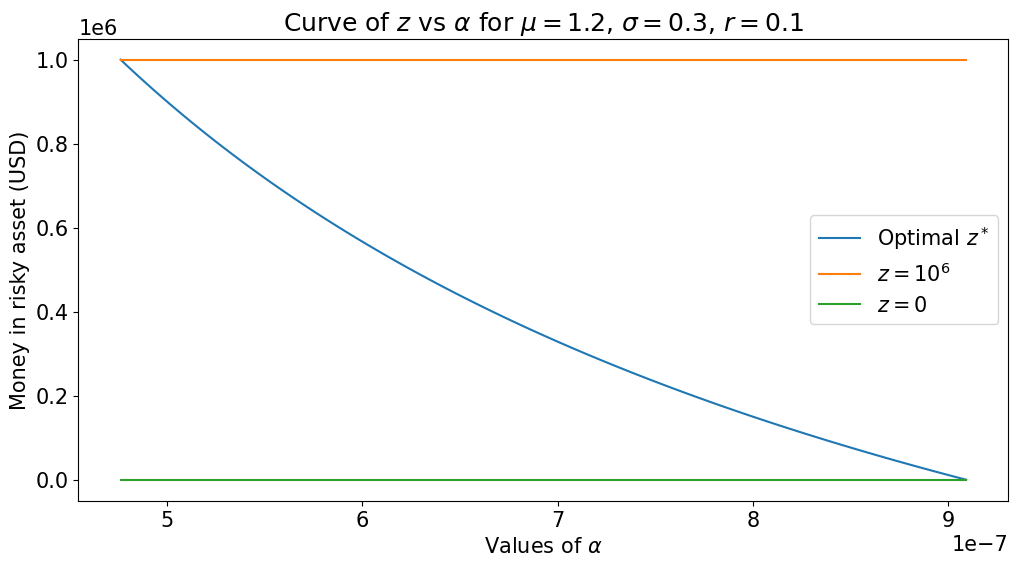

In [6]:
mu = 1.2
sigma = 0.3
r = 0.1

log_min, log_max = get_bounds(mu, sigma, r)
alphas = np.logspace(log_min, log_max, 100)

plt.plot(alphas, z(mu, sigma, r, alphas), label=r"Optimal $z^*$")
plt.plot(alphas, 10**6 * np.ones_like(alphas), label=r"$z = 10^6$")
plt.plot(alphas, np.zeros_like(alphas), label=r"$z = 0$")

plt.title(fr"Curve of $z$ vs $\alpha$ for $\mu=${mu}, $\sigma=${sigma}, $r=${r}")
plt.ylabel("Money in risky asset (USD)")
plt.xlabel(r"Values of $\alpha$")
#plt.xscale("log")
plt.legend()
plt.show()

## Question 3

Assume you are playing a casino game where at every turn, if you bet a
quantity $x$, you will be returned $x \cdot (1 + \alpha)$ with
probability $p$ and returned $x \cdot (1 - \beta)$ with probability
$q = 1 - p$ for $\alpha, \beta \in \mathbb{R}^+$ (i.e., the return on
bet is $\alpha$ with probability $p$ and $-\beta$ with probability
$q = 1-p$) . The problem is to identify a betting strategy that will
maximize one's expected wealth over the long run. The optimal solution
to this problem is known as the Kelly criterion, which involves betting
a constant fraction of one's wealth at each turn (let us denote this
optimal fraction as $f^*$).

It is known that the Kelly criterion (formula for $f^*$) is equivalent
to maximizing the Expected Utility of Wealth after a single bet, with
the Utility function defined as: $U(W) = \log(W)$. Denote your wealth
before placing the single bet as $W_0$. Let $f$ be the fraction (to be
solved for) of $W_0$ that you will bet. Therefore, your bet is
$f \cdot W_0$.

-   Write down the two outcomes for wealth $W$ at the end of your single
    bet of $f \cdot W_0$.

-   Write down the two outcomes for $\log$ (Utility) of $W$.

-   Write down $\mathbb{E}[\log(W)]$.

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

-   Set this derivative to 0 to solve for $f^*$. Verify that this is
    indeed a maxima by evaluating the second derivative at $f^*$. This
    formula for $f^*$ is known as the Kelly Criterion.

-   Convince yourself that this formula for $f^*$ makes intuitive sense
    (in terms of it's dependency on $\alpha$, $\beta$ and $p$).


-   Write down the two outcomes for wealth $W$ at the end of your single
    bet of $f \cdot W_0$.
    
**Answer:**

We have two possible outcomes:
1. If you win, your wealth becomes: $$W_w = W_0  - f \cdot W_0 + f \cdot W_0\cdot (1+\alpha) = W_0 \cdot (1+f\cdot\alpha)$$ with a probability $p$.
2. If you lose, your wealth becomes: $$W_l = W_0 - f \cdot W_0 + f \cdot W_0\cdot (1-\beta)= W_0 \cdot (1-f\cdot\beta)$$ with a probability $q$.

- Write down the two outcomes for $\log$ (Utility) of $W$.

**Answer:**

For the two possible outcomes specified above:
1. The utility of winning is: $$ U(W_w) = \log(W_w) = \log(W_0 \cdot (1+f\cdot\alpha)) = \log(W_0)+\log(1+f\cdot\alpha)$$ 
2. If you lose, your wealth becomes: $$W = \log(W_l) = \log(W_0 \cdot (1-f\cdot\beta)) = \log(W_0)+\log(1-f\cdot\beta)$$ 

- Write down $\mathbb{E}[\log(W)]$.
  
**Answer:**
$$\mathbb E[\log(W)] = p\cdot\log(W_w)+q\cdot\log(W_l) = p\cdot[\log(W_0)+\log(1+f\cdot\alpha)]+q\cdot[\log(W_0)+\log(1-f\cdot\beta)]$$
$$ = \log(W_0) + p\cdot\log(1+f\cdot\alpha) +(1-p)\cdot\log(1-f\cdot\beta)$$

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

**Answer:**

$$\frac\partial{\partial f}\mathbb{E}[\log(W)]= p\frac{\alpha}{1+f\cdot\alpha}+(1-p)\frac{-\beta}{1-f\cdot\beta}$$

-   Set this derivative to 0 to solve for $f^*$. Verify that this is
    indeed a maxima by evaluating the second derivative at $f^*$. This
    formula for $f^*$ is known as the Kelly Criterion.

  **Answer:**
  
  Setting the derivative to 0, we get the Kelly Criterion:
  
 $$p\frac{\alpha}{1+\alpha f^*}+(1-p)\frac{-\beta}{1-\beta f^*} = 0$$
$$p{\alpha}({1-\beta f^*})-(1-p){\beta}({1+\alpha f^*}) = 0$$
$$p{\alpha}-p{\alpha}\beta f^*-(1-p){\beta}-{\alpha}\beta f^*+p\alpha{\beta} f^*= 0$$
$${\alpha}\beta f^* = p{\alpha}-(1-p){\beta}$$
$$f^* = \frac {p{\alpha}-(1-p){\beta}}{\alpha\beta}=\frac {p}{\beta}-\frac {q}{\alpha}$$

The second derivative is:

$$\frac{\partial^2}{\partial f^2}\mathbb{E}[\log(W)]= - p\frac{\alpha^2}{(1+f\cdot\alpha)^2}-(1-p)\frac{\beta^2}{(1-f\cdot\beta)^2}$$

So the second derivative when $f=f^*$ is:
$$\frac{\partial^2}{\partial f^2}\mathbb{E}[\log(W)]\bigg|_{f=f^*}=- p\frac{\alpha^2}{(1+\frac {p{\alpha}-(1-p){\beta}}{\beta})^2}-(1-p)\frac{\beta^2}{(1-\frac {p{\alpha}-(1-p){\beta}}{\alpha})^2} =$$
$$= -\frac{\alpha^2\beta^2}{p({{\alpha}+{\beta}})^2}-\frac{\alpha^2\beta^2}{(1-p)({{\alpha}+{\beta}})^2}
= -\frac{\alpha^2\beta^2}{p(1-p)({{\alpha}+{\beta}})^2}$$

Given that $0\leq p\leq 1$, and the quadratic terms are always going to be positive, the second derivative is negative. This means the $f^*$ value found is a maxima.

-   Convince yourself that this formula for $f^*$ makes intuitive sense
    (in terms of it's dependency on $\alpha$, $\beta$ and $p$).

**Answer:**

The solution for $f^*$ makes intuitive sense. The higher the probability of winning ($p$), which also implies lower probability of losing ($q$), the higher the fraction of wealth that is optimal to bet. Also, if $\alpha$ is high, you can  gain more from each bet, therefore a higher $f^*$ is justified because the reward outweighs the risk. On the other hand, higher $\beta$ has the opposite effect since there is more to lose.

## Question 4

Derive the solution to Merton's Portfolio problem for the case of the
$\log(\cdot)$ Utility function. Note that the derivation in the textbook
is for CRRA Utility function with $\gamma \neq 1$ and the case of the
$\log(\cdot)$ Utility function was left as an exercise to the reader.